In [2]:
from google.colab import files
uploaded = files.upload()
%precision

Saving u.data to u.data


'%r'

In [0]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
rating_column_names = 'user id | item id | rating | timestamp'.split(' | ')
#load the dataset and create the column head
data = pd.read_csv(io.BytesIO(uploaded["u.data"]),sep='\t',header = None, names = rating_column_names)

In [0]:
from sklearn.base import BaseEstimator

class MatrixFactor(BaseEstimator):  
    """Intialise the model with certain parameters"""
    def __init__(self, lam=0.1,alpha=1,k=10,itr=20,min_value=1,max_value=5,user_col_name='user id',item_col_name='item id',response_col_name='rating',max_item_val=1682,max_user_val=943):
        self.lam = lam
        self.alpha = alpha
        self.k = k
        self.itr = itr
        self.min_value = min_value
        self.max_value = max_value
        self.user_col_name = user_col_name
        self.item_col_name = item_col_name
        self.max_item_val = max_item_val
        self.max_user_val = max_user_val
        self.response_col_name = response_col_name      
     
    '''Fit function is used by the GridSearch, return self'''
    def fit(self, true_data, y=None):
        X= true_data.copy(deep=True)
        #normalize the ratings as per the requirement 
        X[self.response_col_name] = (X[self.response_col_name]-self.min_value)/(self.max_value-self.min_value) 
        #create the rating matrix
        self.matrix_ = X.pivot(index=self.user_col_name,
                               columns=self.item_col_name,
                               values=self.response_col_name).fillna(0)
        user_dict={}
        #identify item for each user
        for us in pd.unique(X[self.user_col_name]):
          user_dict[us]=list(X[X[self.user_col_name]==us][self.item_col_name])
  
        #average of number of rated items
        self.general_bias_ = np.sum(X[self.response_col_name])/len(X[self.response_col_name])

        citr = 0
        #intialise the random P and Q matrix
        self.p_ = np.random.normal(scale = 1.0/self.k, size =(self.max_user_val+1,self.k))
        self.q_ = np.random.normal(scale = 1.0/self.k, size =(self.max_item_val+1,self.k))
        i = 0
        error = {}
        #initialize the bias for each item and user value
        self.item_bias_ = np.zeros(self.max_item_val+1)
        self.user_bias_ = np.zeros(self.max_user_val+1)
        #run the iteration 
        while(i<self.itr):
          pred_rat=[]
          actual = []
          #shuffle the users
          np.random.shuffle([user_dict.keys()])
          for user,v in user_dict.items():
            #shuffle the items
            np.random.shuffle(v)
          for item in v:
            #evaluate the difference between predicted and actual rating
            score = self.matrix_[item][user]
            #predict a score
            pred_score = self.general_bias_+self.item_bias_[item]+self.user_bias_[user]+np.dot(self.p_[user,:],self.q_[item,:].T)
            #delta value
            delta = score - pred_score
            #update the bias
            self.item_bias_[item]+=self.alpha * (delta - self.lam * self.item_bias_[item])
            self.user_bias_[user]+=self.alpha * (delta - self.lam * self.user_bias_[user])
            self.p_[user,:]=self.p_[user,:]+self.alpha*((float(delta)*self.q_[item,:])-(self.lam*self.p_[user,:]))
            self.q_[item,:]=self.q_[item,:]+self.alpha*((float(delta)*self.p_[user,:])-(self.lam*self.q_[item,:]))
          i+=1
        return self


    def predict(self, X, y=None):
      actual_score = []
      y_pred = []
      #iterate over all the given rows and predict each rating 
      for index,row in X.iterrows():
        user,item=int(row[self.user_col_name]),int(row[self.item_col_name])
        actual_score.append(row[self.response_col_name])
        y_pred_unnormal = self.general_bias_+self.user_bias_[user]+self.item_bias_[item]+(np.dot(self.p_[user,:],self.q_[item,:].T))
        #stack the values so that we can evaluate RMSE and difference of 2 lists
        y_pred.append(((self.max_value-self.min_value)*(y_pred_unnormal))+self.min_value)
      return np.sqrt(np.sum((np.array(actual_score) - np.array(y_pred)) ** 2)/len(actual_score))

    def score(self, X, y=None):
      #we have to return a number from this method for our beloved GridSearch 
      return self.predict(X)
    
    def _prediction(self,X,y=None):
      #method to return the list of predicted rating for list of item and user
      actual_score = []
      y_pred = []
      for index,row in X.iterrows():
        user,item=int(row[self.user_col_name]),int(row[self.item_col_name])
        actual_score.append(row[self.response_col_name])
        y_pred.append(self.general_bias_+self.user_bias_[user]+self.item_bias_[item]+(np.dot(self.p_[user,:],self.q_[item,:].T)))
      return y_pred
      
     

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#Create Pipeline for both KNN and Decision Tree Classifier

rcmObj= MatrixFactor()
#rcm._model_config(user_col_name='user id',item_col_name='item id',response_col_name='rating',max_item_val=1682,max_user_val=943)

rcm = Pipeline([
    ("classifier", rcmObj)
])

'''
Define the parameter grid to be explored
'''

param_grid = [{"classifier__lam" :  [0.01,0.001,0.1],
               "classifier__alpha" : [1e-5,1e-4,1e-3],
               "classifier__k" : [20,25,30],
              "classifier__itr" : [20,25,30]}]


rcm_grid = GridSearchCV(rcm, cv = 3, n_jobs = 3,
                          param_grid = param_grid[0], verbose = 1, refit = True)
rcm_grid.fit(data)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.0min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 21.8min
[Parallel(n_jobs=3)]: Done 243 out of 243 | elapsed: 27.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('classifier', MatrixFactor(alpha=1, item_col_name='item id', itr=20, k=10, lam=0.1,
       max_item_val=1682, max_user_val=943, max_value=5, min_value=1,
       response_col_name='rating', user_col_name='user id'))]),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'classifier__lam': [0.01, 0.001, 0.1], 'classifier__alpha': [1e-05, 0.0001, 0.001], 'classifier__k': [20, 25, 30], 'classifier__itr': [20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [69]:
rcm_grid.best_estimator_

Pipeline(memory=None,
     steps=[('classifier', MatrixFactor(alpha=0.0001, item_col_name='item id', itr=20, k=20, lam=0.001,
       max_item_val=1682, max_user_val=943, max_value=5, min_value=1,
       response_col_name='rating', user_col_name='user id'))])

Optimal Hyperparameters 
{'classifier__alpha': 0.0001, 'classifier__itr': 20, 'classifier__k': 20, 'classifier__lam': 0.001}

Best score 1.1268215145289613


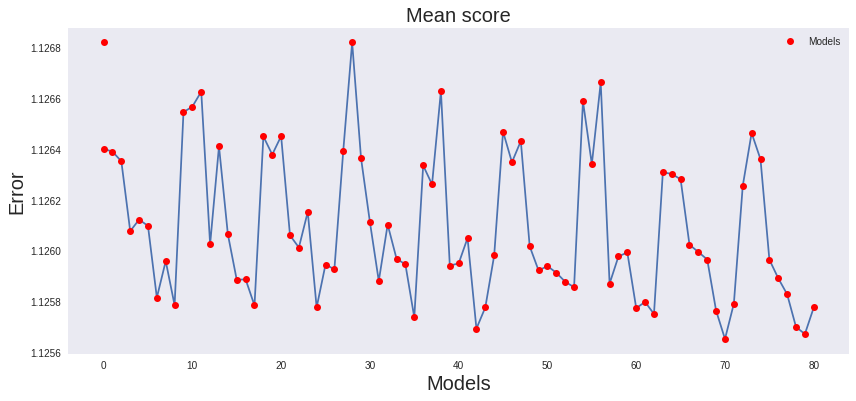

In [73]:
'''
Plotting the results for KNN GridSearch
'''
print("Optimal Hyperparameters \n" + str(rcm_grid.best_params_) + "\n")
print("Best score " + str(rcm_grid.best_score_))

plt.figure(figsize = (14, 6))
plt.title("Mean score", fontsize = 20)
plt.plot(rcm_grid.cv_results_["mean_test_score"])
plt.plot(rcm_grid.cv_results_["mean_test_score"], "ro", label = "Models")
plt.plot(rcm_grid.best_score_, "ro")
plt.xlabel('Models', fontsize = 20)
plt.ylabel('Error', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [71]:
from sklearn.model_selection import cross_validate
#perform cross validation using the best hyperparameters on the training set
scoreRCM = cross_validate(rcm.set_params(**rcm_grid.best_params_), data, cv=3)
'''
Fitting time and test score for 3 cv folds
'''
print('===============FITTING TIME=========================')
print('  ',scoreRCM['fit_time'])

print('===============TEST SCORE=========================')
print('  ',scoreRCM['test_score'])

===============FITTING TIME=========================
   [0.73660469 0.71380711 0.68778944]
===============TEST SCORE=========================
   [1.14681517 1.1141272  1.11816276]


In [56]:
from google.colab import files
uploaded = files.upload()
%precision
rating_column_names = 'user id | item id | rating | timestamp'.split(' | ')
test_data1 = pd.read_csv(io.BytesIO(uploaded["u1.test"]),sep='\t',header = None, names = rating_column_names)


Saving u1.test to u1 (1).test


In [0]:
#using the best paramters of the gridsearch we evaluate our performance on the test set 

'''
Instead of performing 3 fold CV on test set, we will be using 3 different dataset provided along
with the original dataset. 
We will then average the entire test error to get the final error
'''
rcm.set_params(**rcm_grid.best_params_)
rcm.fit(data)
score1_test = rcm.score(test_data1)

In [58]:
uploaded = files.upload()
%precision
rating_column_names = 'user id | item id | rating | timestamp'.split(' | ')
test_data2 = pd.read_csv(io.BytesIO(uploaded["u2.test"]),sep='\t',header = None, names = rating_column_names)

score2_test = rcm.score(test_data2)

Saving u2.test to u2 (1).test


In [59]:
uploaded = files.upload()
%precision
rating_column_names = 'user id | item id | rating | timestamp'.split(' | ')
test_data3 = pd.read_csv(io.BytesIO(uploaded["u3.test"]),sep='\t',header = None, names = rating_column_names)

score3_test = rcm.score(test_data3)

Saving u3.test to u3 (3).test


In [74]:
print(f"Average test error is {np.around(np.sum(score1_test+score2_test+score3_test)/3,3)} using our custom implementation")

Average test error is 1.133 using our custom implementation


**Our model produces RMSE of 1.133 using the best hyperparameters our GridSearch produced**
